1. В коде из методички реализуйте один или несколько критериев останова: минимальное количество объектов в листе (`min_leaf`), максимальная глубина дерева, максимальное количество листьев и т.д. Добавьте эти критерии в параметры функции `build_tree` и проверьте ее работоспособность с помощью визуализации дерева (функция `print_tree()`). 
2. (\*) Для задачи классификации обучите дерево решений с использованием критериев разбиения Джини и Энтропия. Сравните качество классификации, сделайте выводы.
2. (\*) Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, а критерий Джини на дисперсию значений. Проверьте точность предсказания дерева на одной из метрик задачи регрессии.

In [2]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [3]:
def get_classes(labels):
    # подсчет количества объектов разных классов
    classes = {}  # сформируем словарь "класс: количество объектов"
    for label in labels:
        if label not in classes:
            classes[label] = 0 
        classes[label] += 1
    return classes

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels, classification=True):  # добавлен параметр для реализации задачи регрессии
        self.data = data
        self.labels = labels
        self.prediction = self.predict(classification)
        
    def predict(self, classification):
        if classification:
            classes = get_classes(self.labels)
            #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
            prediction = max(classes, key=classes.get)
        else:
            prediction = np.mean(self.labels)  # для регрессии вычисляем среднее по выборке
        return prediction   

In [6]:
# Расчет критерия Джини

def gini(labels):
    classes = classes = get_classes(labels)
    
    #  расчет критерия
    impurity = 1 # коэффициент неопределенности Джини
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# энтропийный критерий для задачи №2
def entropy(labels):
    classes = classes = get_classes(labels)
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        if p == 0.0:
            continue
        impurity -= p * np.log2(p)
        
    return impurity

In [8]:
# дисперсия для задачи №3
def variance(labels):
    return np.var(labels)

In [9]:
# Расчет качества

def quality(left_labels, right_labels, current_criteria, criteria=gini):
    """
    Расчёт качества.

    :param criteria: критерий информативности, может принимать значения gini, entropy, variance.
    Значение variance для задачи регрессии.
    :return: функционал качества
    """
    
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_criteria - p * criteria(left_labels) - (1 - p) * criteria(right_labels)

In [10]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf=np.inf, criteria=gini):

    current_criteria = criteria(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_criteria, criteria)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_leaf=1, max_depth=np.inf, criteria=gini, depth=0):
    
    #  Базовый случай по макс.глубине для узлов (корень = 0я глубина)
    if depth == max_depth:
        return Leaf(data, labels, (criteria != variance))  # (criteria != variance) - для разграничения задач регр/класс

    quality, t, index = find_best_split(data, labels, min_leaf, criteria)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels, (criteria != variance))  # (criteria != variance) - для разграничения задач регр/класс

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, min_leaf, max_depth, criteria, depth+1)
    false_branch = build_tree(false_data, false_labels, min_leaf, max_depth, criteria, depth+1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [14]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [15]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification( n_samples=1000,
                                                      n_features=2, n_informative=2, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=1, 
                                                      random_state=42)

C:\Work\Anaconda\lib\site-packages\sklearn\datasets\samples_generator.py:189: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros(n_samples, dtype=np.int)


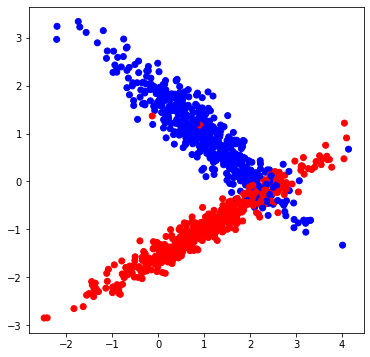

In [16]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [17]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size = 0.3,
                                                                    random_state = 42)

In [18]:
class ColorText:
    PURPLE = '\033[1;35;48m'
    CYAN = '\033[1;36;48m'
    BOLD = '\033[1;39;48m'
    GREEN = '\033[1;34;48m'
    BLUE = '\033[1;44;48m'
    ORANGE = '\033[1;32;48m'
    YELLOW = '\033[1;33;48m'
    RED = '\033[1;31;48m'
    BLACK = '\033[1;30;48m'
    UNDERLINE = '\033[1;37;48m'
    END = '\033[1;37;0m'

In [19]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(ColorText.ORANGE + spacing + ' ЛИСТ' 
                  + ': прогноз = ' + str(node.prediction) 
                  + ', объектов = ' + str(len(node.labels)) 
                  + ColorText.END)
        return

    # Выведем значение индекса и порога на этом узле
    print(ColorText.GREEN + spacing + 'УЗЕЛ'  
              + ': индекс = ' + str(node.index) 
              + ', порог = ' + str(round(node.t, 2))
              + ColorText.END)

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Левая ветка:')
    print_tree(node.true_branch, spacing + "   ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Правая ветка:')
    print_tree(node.false_branch, spacing + "   ")

In [20]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, min_leaf=10, max_depth=10)
print_tree(my_tree)

УЗЕЛ: индекс = 1, порог = -0.16
--> Левая ветка:
   УЗЕЛ: индекс = 0, порог = 2.61
   --> Левая ветка:
      УЗЕЛ: индекс = 1, порог = -0.42
      --> Левая ветка:
         УЗЕЛ: индекс = 0, порог = 2.07
         --> Левая ветка:
            УЗЕЛ: индекс = 1, порог = -0.72
            --> Левая ветка:
                ЛИСТ: прогноз = 0, объектов = 225
            --> Правая ветка:
               УЗЕЛ: индекс = 0, порог = 1.51
               --> Левая ветка:
                   ЛИСТ: прогноз = 0, объектов = 10
               --> Правая ветка:
                   ЛИСТ: прогноз = 0, объектов = 35
         --> Правая ветка:
             ЛИСТ: прогноз = 0, объектов = 15
      --> Правая ветка:
         УЗЕЛ: индекс = 1, порог = -0.25
         --> Левая ветка:
            УЗЕЛ: индекс = 0, порог = 2.08
            --> Левая ветка:
                ЛИСТ: прогноз = 0, объектов = 16
            --> Правая ветка:
                ЛИСТ: прогноз = 0, объектов = 12
         --> Правая ветка:
           

In [21]:
# Построим дерево с энтропийным критерием
entr_tree = build_tree(train_data, train_labels, min_leaf=10, max_depth=10, criteria=entropy)
print_tree(entr_tree)

УЗЕЛ: индекс = 1, порог = -0.16
--> Левая ветка:
   УЗЕЛ: индекс = 0, порог = 1.9
   --> Левая ветка:
      УЗЕЛ: индекс = 1, порог = -0.72
      --> Левая ветка:
          ЛИСТ: прогноз = 0, объектов = 225
      --> Правая ветка:
         УЗЕЛ: индекс = 0, порог = 1.79
         --> Левая ветка:
            УЗЕЛ: индекс = 0, порог = 1.5
            --> Левая ветка:
                ЛИСТ: прогноз = 0, объектов = 10
            --> Правая ветка:
               УЗЕЛ: индекс = 0, порог = 1.65
               --> Левая ветка:
                   ЛИСТ: прогноз = 0, объектов = 15
               --> Правая ветка:
                   ЛИСТ: прогноз = 0, объектов = 10
         --> Правая ветка:
             ЛИСТ: прогноз = 0, объектов = 12
   --> Правая ветка:
      УЗЕЛ: индекс = 0, порог = 2.61
      --> Левая ветка:
         УЗЕЛ: индекс = 1, порог = -0.42
         --> Левая ветка:
            УЗЕЛ: индекс = 1, порог = -0.48
            --> Левая ветка:
                ЛИСТ: прогноз = 0, объектов 

In [22]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [23]:
# Получим ответы для обучающей выборки 
entr_train_answers = predict(train_data, entr_tree)

# И получим ответы для тестовой выборки
entr_answers = predict(test_data, entr_tree)

In [24]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [25]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
entr_train_accuracy = accuracy_metric(train_labels, entr_train_answers)
train_accuracy, entr_train_accuracy

(95.85714285714285, 95.57142857142857)

In [26]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
entr_test_accuracy = accuracy_metric(test_labels, entr_answers)
test_accuracy, entr_test_accuracy

(92.66666666666666, 93.33333333333333)

C:\Work\Anaconda\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
C:\Work\Anaconda\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0.5, 1.0, 'Test accuracy=92.67')

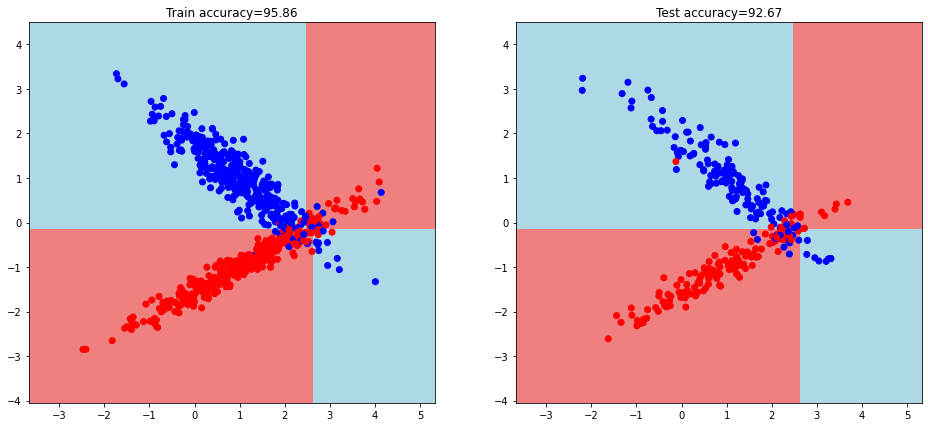

In [27]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

C:\Work\Anaconda\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys
C:\Work\Anaconda\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]


Text(0.5, 1.0, 'Test accuracy for entropy=93.33')

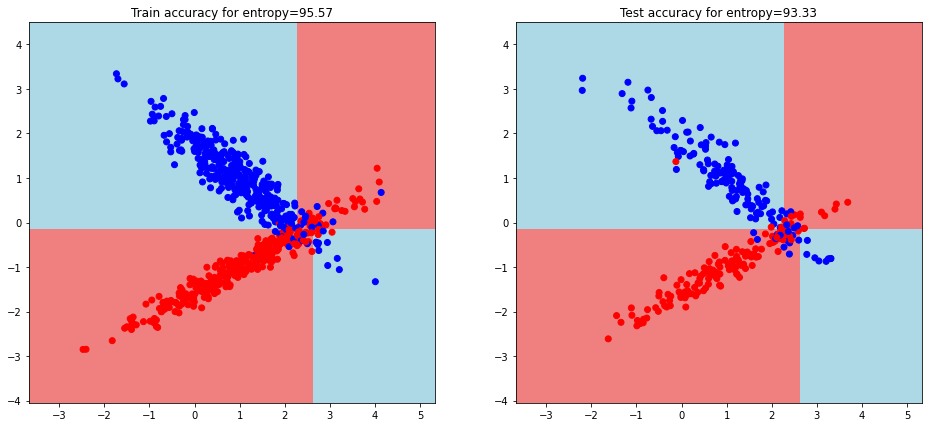

In [28]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], entr_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy for entropy={entr_train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy for entropy={entr_test_accuracy:.2f}')

По задаче №2: оба варианта деревьев показали примерно равные результаты, но в случае использования критерия энтропии Шеннона на тестовых данных результат оказался лучше, чем для критерия Джини

**Задача №3**

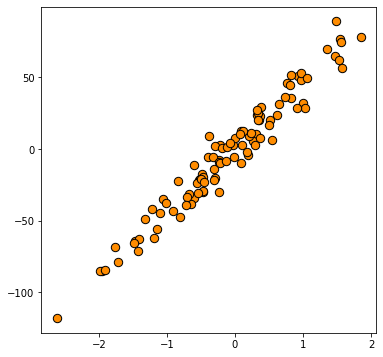

In [29]:
# 3 задание
from sklearn import datasets

regression_data, regression_labels = datasets.make_regression(n_samples=100, 
                                                      n_features=1, noise=10,
                                                      random_state=42)
plt.figure(figsize=(6,6))
plt.scatter(regression_data, regression_labels, c='darkorange', edgecolor='black', s=70);

In [30]:
rtrain_data, rtest_data, rtrain_labels, rtest_labels = train_test_split(regression_data, 
                                                                    regression_labels, 
                                                                    test_size = 0.3,
                                                                    random_state = 42)

In [31]:
reg_tree = build_tree(rtrain_data, rtrain_labels, min_leaf=3, max_depth=3, criteria=variance)

In [32]:
print_tree(reg_tree)

УЗЕЛ: индекс = 0, порог = -0.23
--> Левая ветка:
   УЗЕЛ: индекс = 0, порог = -1.2
   --> Левая ветка:
      УЗЕЛ: индекс = 0, порог = -1.72
      --> Левая ветка:
          ЛИСТ: прогноз = -90.32423990914594, объектов = 5
      --> Правая ветка:
          ЛИСТ: прогноз = -63.25858789364454, объектов = 3
   --> Правая ветка:
      УЗЕЛ: индекс = 0, порог = -0.54
      --> Левая ветка:
         УЗЕЛ: индекс = 0, порог = -0.65
         --> Левая ветка:
             ЛИСТ: прогноз = -37.25667206314706, объектов = 9
         --> Правая ветка:
             ЛИСТ: прогноз = -29.276642113230054, объектов = 3
      --> Правая ветка:
         УЗЕЛ: индекс = 0, порог = -0.46
         --> Левая ветка:
             ЛИСТ: прогноз = -22.926098031444315, объектов = 5
         --> Правая ветка:
             ЛИСТ: прогноз = -12.613098388638317, объектов = 8
--> Правая ветка:
   УЗЕЛ: индекс = 0, порог = 0.65
   --> Левая ветка:
      УЗЕЛ: индекс = 0, порог = 0.31
      --> Левая ветка:
         УЗЕЛ: ин

In [33]:
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2)
    return err

In [34]:
# Получим ответы для обучающей выборки 
rtrain_answers = predict(rtrain_data, reg_tree)

# И получим ответы для тестовой выборки
ranswers = predict(rtest_data, reg_tree)

train_mse = calc_mse(rtrain_labels, rtrain_answers)
test_mse = calc_mse(rtest_labels, ranswers)

train_mse, test_mse

(62.7212339023336, 122.58690920970325)

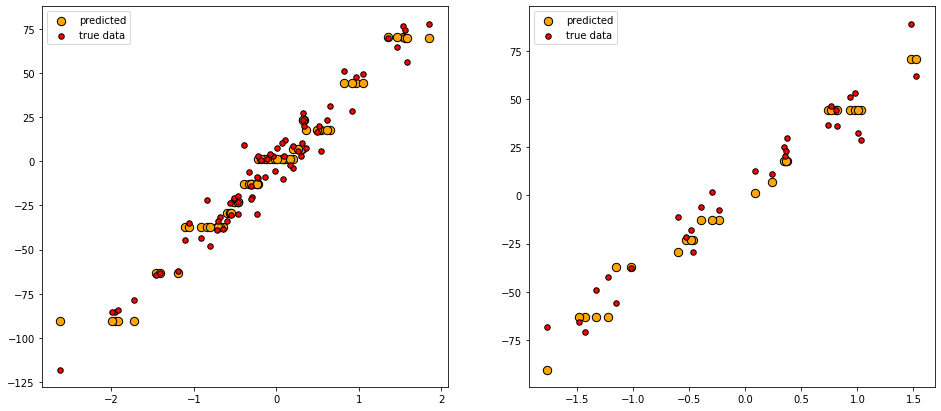

In [35]:
plt.figure(figsize = (16, 7))
plt.subplot(1, 2, 1)

plt.scatter(rtrain_data, rtrain_answers, c='orange', label='predicted', edgecolor='black', s=70)
plt.scatter(rtrain_data, rtrain_labels, c='red', label='true data', edgecolor='black', s=30)
plt.legend()

plt.subplot(1, 2, 2)

plt.scatter(rtest_data, ranswers, c='orange', label='predicted', edgecolor='black', s=70)
plt.scatter(rtest_data, rtest_labels, c='red', label='true data', edgecolor='black', s=30)
plt.legend()

plt.show()